### Decision Tree

Logistic is performed on a clinical data set with patient demographics and tumor attributes. The label is the survival status of the patient.

#### Step 1: Data Prep

The data is prepared the same way as multinomial NB, then models are compared. Continuous features are descritized, then df is one hot encoded.

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [8]:
file="cleaned_cgga_693_clinical.csv"
df=pd.read_csv(file)
df.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,survival_days,survival_status,radio_status,chemo_status,mutation_status,codeletion_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,Non-codel
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel


In [9]:
# drop unnecessary or redundant columns
df = df.drop(columns=['sample_id','survival_days'])

In [10]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['age_binned'] = discretizer.fit_transform(df[['age']])
# retrieve bin edges to interpret output of NB model later
bin_edges = discretizer.bin_edges_[0]
print(bin_edges)
df=df.drop(columns='age', axis = 1)
df.head()

[11. 33. 40. 46. 55. 76.]


,tumor_type,tumor_histology,tumor_grade,gender,survival_status,radio_status,chemo_status,mutation_status,codeletion_status,age_binned
0,P,anaplastic astrocyma,3,F,1.0,1.0,1.0,Wildtype,Non-codel,2.0
1,P,oligodendroglioma,2,F,0.0,0.0,1.0,Mutant,Codel,3.0
2,P,astrocytoma,2,M,1.0,1.0,1.0,Mutant,Non-codel,2.0
3,R,oligodendroglioma,2,M,1.0,1.0,1.0,Mutant,Non-codel,2.0
4,P,astrocytoma,2,M,1.0,0.0,1.0,Wildtype,Non-codel,2.0


In [11]:
# use one hot encoding to tranform catagorical feautures

from sklearn.preprocessing import OneHotEncoder

#  categorical columns to encode
categorical_cols = ['tumor_type', 'tumor_histology', 'tumor_grade',
                    'gender','radio_status','chemo_status','mutation_status',
                    'codeletion_status','age_binned']  

# fit encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df[categorical_cols])

# get the new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# turn back into a DataFrame
encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=df.index)

# drop original columns and join the new encoded ones
df = df.drop(columns=categorical_cols).join(encoded_df)
df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,survival_status,tumor_type_P,tumor_type_R,tumor_histology_anaplastic astrocyma,tumor_histology_anaplastic oligoastrocytoma,tumor_histology_astrocytoma,tumor_histology_glioblastoma,tumor_histology_oligoastrocytoma,tumor_histology_oligodendroglioma,tumor_grade_2,...,chemo_status_1.0,mutation_status_Mutant,mutation_status_Wildtype,codeletion_status_Codel,codeletion_status_Non-codel,age_binned_0.0,age_binned_1.0,age_binned_2.0,age_binned_3.0,age_binned_4.0
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Step 2: Split data into training and testing

In [12]:
training, testing = train_test_split(df, test_size=.3)
##  Save the Labels and then remove them from the Training and Testing data
training_label = training["survival_status"]
training=training.drop(["survival_status"], axis=1)
testing_label = testing["survival_status"]
testing=testing.drop(["survival_status"], axis=1)
print("Testing:", testing)

Testing:      tumor_type_P  tumor_type_R  tumor_histology_anaplastic astrocyma  \
342           1.0           0.0                                   1.0   
338           1.0           0.0                                   0.0   
139           1.0           0.0                                   0.0   
379           1.0           0.0                                   0.0   
440           0.0           1.0                                   1.0   
..            ...           ...                                   ...   
232           1.0           0.0                                   1.0   
405           0.0           1.0                                   0.0   
549           0.0           1.0                                   0.0   
429           1.0           0.0                                   0.0   
72            1.0           0.0                                   1.0   

     tumor_histology_anaplastic oligoastrocytoma  tumor_histology_astrocytoma  \
342                              

## Run Decision Tree

In [13]:
import graphviz

### Tree #1

In [14]:
##Instantiate the decision tree using the defaults.
MyDT_Classifier = DecisionTreeClassifier()
MyDT_Classifier = MyDT_Classifier.fit(training, training_label)

In [15]:
## Get all the feature/variable names. We often need these for
## visualizations.
FeatureNames=training.columns.values ## get all the feature/variable names
print(FeatureNames)
ClassNames=MyDT_Classifier.classes_ ## Get the class names
print(ClassNames)

['tumor_type_P' 'tumor_type_R' 'tumor_histology_anaplastic astrocyma'
 'tumor_histology_anaplastic oligoastrocytoma'
 'tumor_histology_astrocytoma' 'tumor_histology_glioblastoma'
 'tumor_histology_oligoastrocytoma' 'tumor_histology_oligodendroglioma'
 'tumor_grade_2' 'tumor_grade_3' 'tumor_grade_4' 'gender_F' 'gender_M'
 'radio_status_0.0' 'radio_status_1.0' 'chemo_status_0.0'
 'chemo_status_1.0' 'mutation_status_Mutant' 'mutation_status_Wildtype'
 'codeletion_status_Codel' 'codeletion_status_Non-codel' 'age_binned_0.0'
 'age_binned_1.0' 'age_binned_2.0' 'age_binned_3.0' 'age_binned_4.0']
[0. 1.]


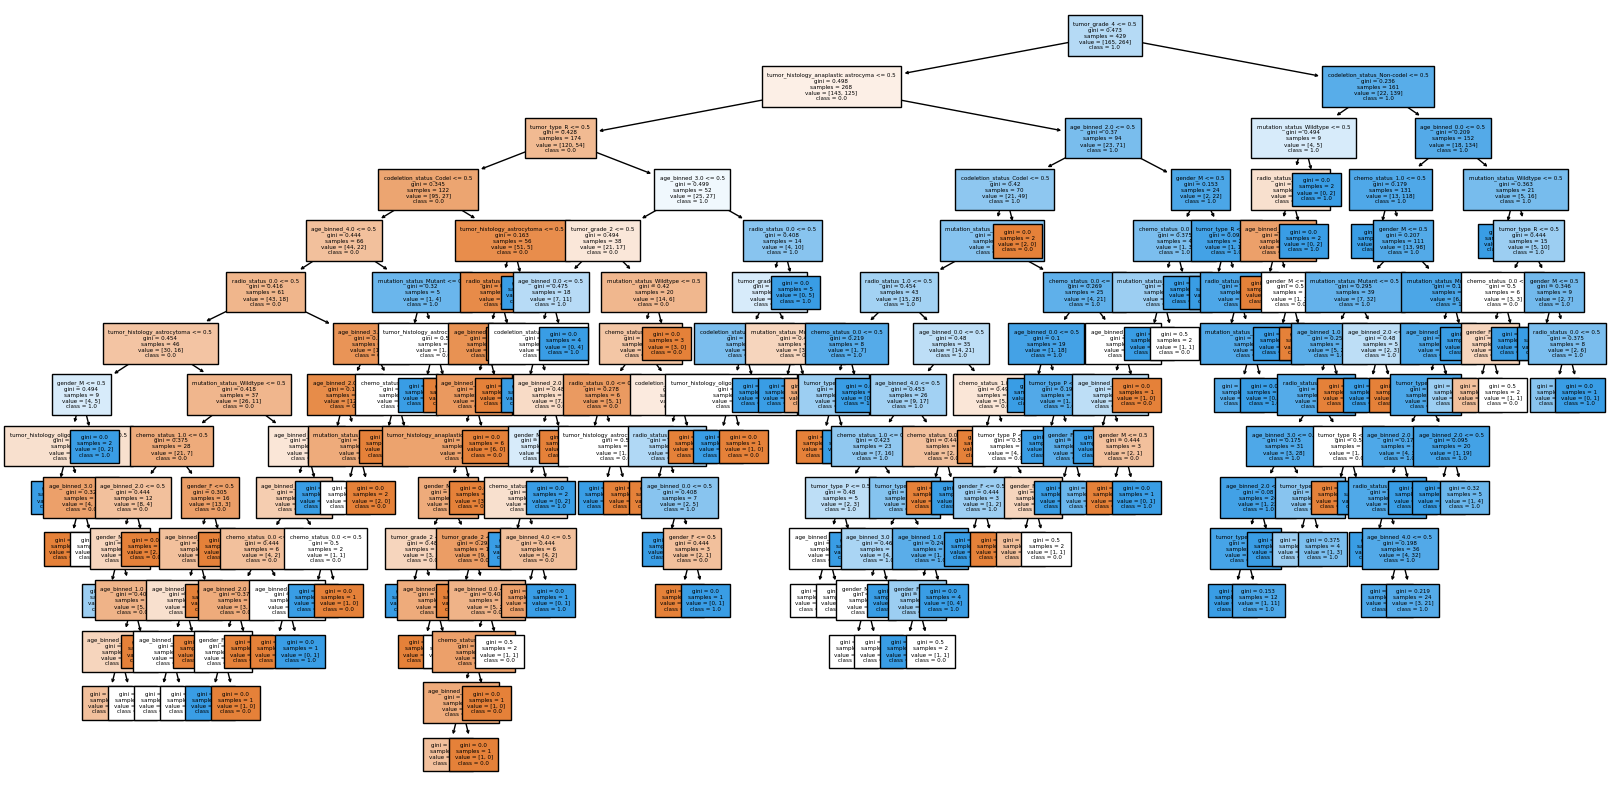

In [26]:
# convert to strings
FeatureNames = [str(f) for f in FeatureNames]
ClassNames = [str(c) for c in ClassNames]
# visualize tree
plt.figure(figsize=(20,10))
MyPlot=tree.plot_tree(MyDT_Classifier,
                   feature_names=FeatureNames,  
                   class_names=ClassNames,
                   filled=True,
                     fontsize=4)


In [60]:
from sklearn.tree import export_text

#print(export_text(MyDT_Classifier, feature_names=FeatureNames))

[0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
[[43 35]
 [20 87]]


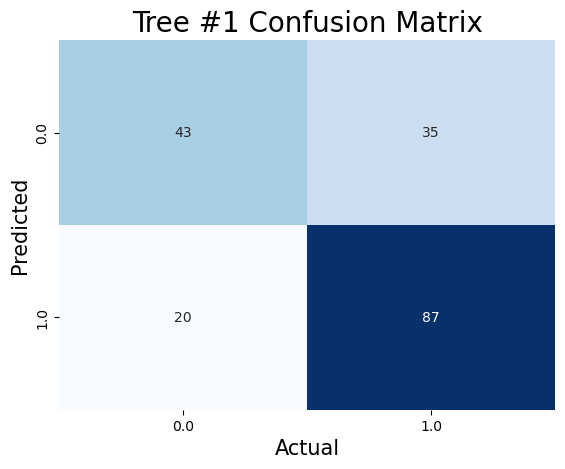

In [46]:
Prediction=MyDT_Classifier.predict(testing)
print(Prediction)

Actual_Labels=testing_label
Predicted_Labels=Prediction

##Create the Basic Confusion Matrix
My_Conf_Mat = confusion_matrix(Actual_Labels, Predicted_Labels)
print(My_Conf_Mat)
##Create the fancy CM using Seaborn
sns.heatmap(My_Conf_Mat, annot=True,cmap='Blues',xticklabels=ClassNames, 
yticklabels=ClassNames, cbar=False)
plt.title("Tree #1 Confusion Matrix",fontsize=20)
plt.xlabel("Actual", fontsize=15)
plt.ylabel("Predicted", fontsize=15)

plt.savefig("seaborn_plot.jpg")


### Tree #2

In [37]:
training_2 = training.drop(columns='tumor_grade_4', axis =1)
Tree2 = DecisionTreeClassifier()
Tree2.fit(training_2, training_label)



DecisionTreeClassifier()

In [38]:
FeatureNames_2=training_2.columns.values ## get all the feature/variable names
print(FeatureNames)
ClassNames_2=Tree2.classes_ ## Get the class names
print(ClassNames)

['tumor_type_P', 'tumor_type_R', 'tumor_histology_anaplastic astrocyma', 'tumor_histology_anaplastic oligoastrocytoma', 'tumor_histology_astrocytoma', 'tumor_histology_glioblastoma', 'tumor_histology_oligoastrocytoma', 'tumor_histology_oligodendroglioma', 'tumor_grade_2', 'tumor_grade_3', 'tumor_grade_4', 'gender_F', 'gender_M', 'radio_status_0.0', 'radio_status_1.0', 'chemo_status_0.0', 'chemo_status_1.0', 'mutation_status_Mutant', 'mutation_status_Wildtype', 'codeletion_status_Codel', 'codeletion_status_Non-codel', 'age_binned_0.0', 'age_binned_1.0', 'age_binned_2.0', 'age_binned_3.0', 'age_binned_4.0']
['0.0', '1.0']


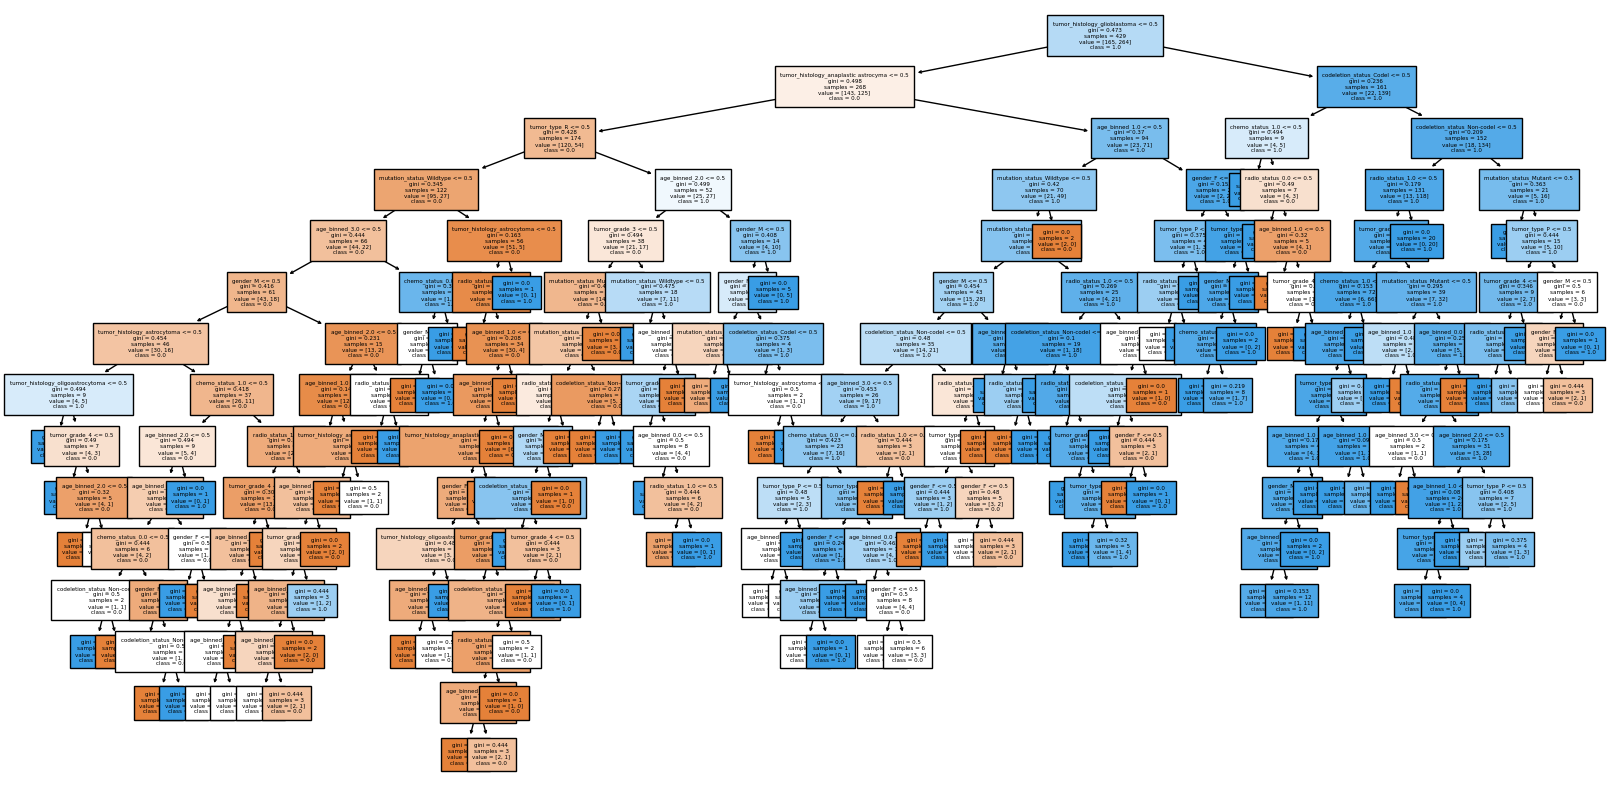

In [39]:
FeatureNames_2 = [str(f) for f in FeatureNames_2]
ClassNames_2 = [str(c) for c in ClassNames_2]
# visualize tree
plt.figure(figsize=(20,10))
MyPlot=tree.plot_tree(Tree2,
                   feature_names=FeatureNames,  
                   class_names=ClassNames,
                   filled=True,
                     fontsize=4)

In [47]:
from sklearn.tree import export_text

#print(export_text(Tree2, feature_names=FeatureNames_2))

[1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
[[40 38]
 [22 85]]


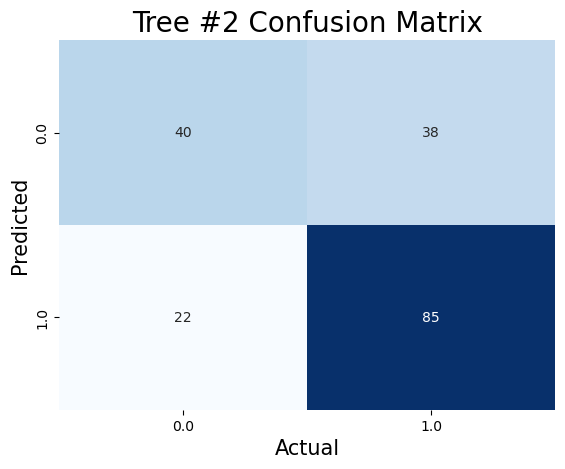

In [45]:
testing_2=testing.drop(columns='tumor_grade_4', axis=1)
Prediction=Tree2.predict(testing_2)
print(Prediction)

Actual_Labels=testing_label
Predicted_Labels=Prediction

##Create the Basic Confusion Matrix
My_Conf_Mat = confusion_matrix(Actual_Labels, Predicted_Labels)
print(My_Conf_Mat)
##Create the fancy CM using Seaborn
sns.heatmap(My_Conf_Mat, annot=True,cmap='Blues',xticklabels=ClassNames, 
yticklabels=ClassNames, cbar=False)
plt.title("Tree #2 Confusion Matrix",fontsize=20)
plt.xlabel("Actual", fontsize=15)
plt.ylabel("Predicted", fontsize=15)

plt.savefig("seaborn_plot.jpg")


### Tree #3

In [52]:
training_3 = training_2.drop(columns='tumor_histology_glioblastoma', axis =1)
Tree3 = DecisionTreeClassifier()
Tree3.fit(training_3, training_label)

DecisionTreeClassifier()

In [53]:
FeatureNames_3=training_3.columns.values ## get all the feature/variable names
print(FeatureNames)
ClassNames_3=Tree3.classes_ ## Get the class names
print(ClassNames)

['tumor_type_P', 'tumor_type_R', 'tumor_histology_anaplastic astrocyma', 'tumor_histology_anaplastic oligoastrocytoma', 'tumor_histology_astrocytoma', 'tumor_histology_glioblastoma', 'tumor_histology_oligoastrocytoma', 'tumor_histology_oligodendroglioma', 'tumor_grade_2', 'tumor_grade_3', 'tumor_grade_4', 'gender_F', 'gender_M', 'radio_status_0.0', 'radio_status_1.0', 'chemo_status_0.0', 'chemo_status_1.0', 'mutation_status_Mutant', 'mutation_status_Wildtype', 'codeletion_status_Codel', 'codeletion_status_Non-codel', 'age_binned_0.0', 'age_binned_1.0', 'age_binned_2.0', 'age_binned_3.0', 'age_binned_4.0']
['0.0', '1.0']


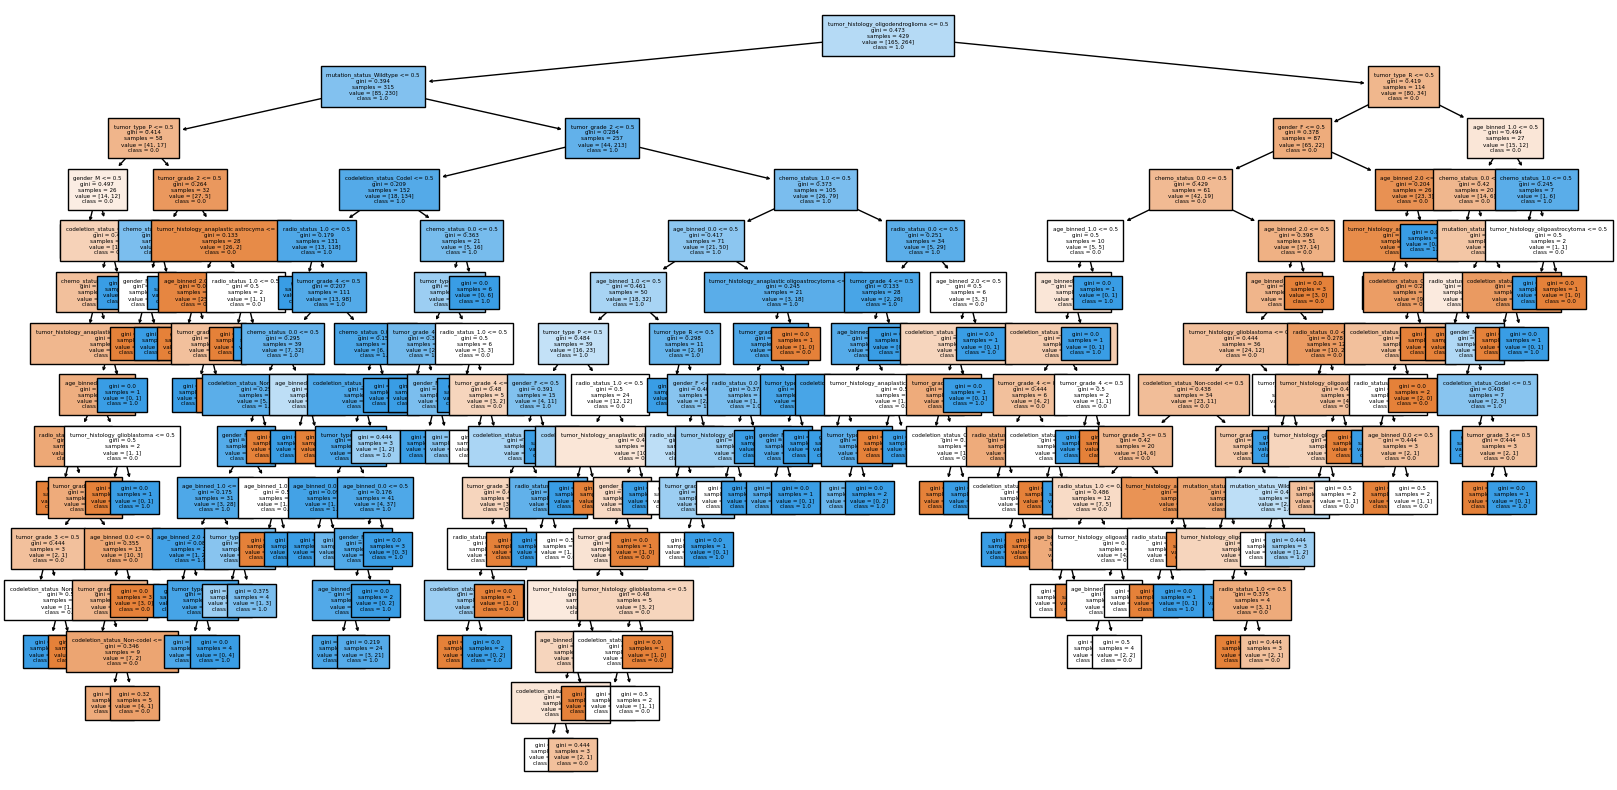

In [54]:
FeatureNames_3 = [str(f) for f in FeatureNames_3]
ClassNames_3 = [str(c) for c in ClassNames_3]
# visualize tree
plt.figure(figsize=(20,10))
MyPlot=tree.plot_tree(Tree3,
                   feature_names=FeatureNames,  
                   class_names=ClassNames,
                   filled=True,
                     fontsize=4)

In [59]:
#print(export_text(Tree3, feature_names=FeatureNames_3))

[0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.]
[[43 35]
 [26 81]]


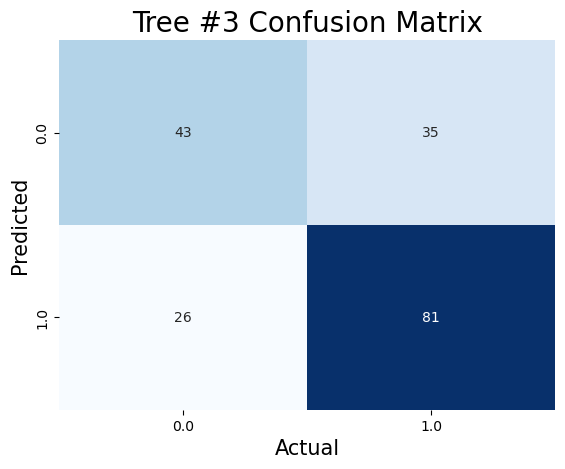

In [56]:
testing_3=testing_2.drop(columns='tumor_histology_glioblastoma', axis=1)
Prediction=Tree3.predict(testing_3)
print(Prediction)

Actual_Labels=testing_label
Predicted_Labels=Prediction

##Create the Basic Confusion Matrix
My_Conf_Mat = confusion_matrix(Actual_Labels, Predicted_Labels)
print(My_Conf_Mat)
##Create the fancy CM using Seaborn
sns.heatmap(My_Conf_Mat, annot=True,cmap='Blues',xticklabels=ClassNames, 
yticklabels=ClassNames, cbar=False)
plt.title("Tree #3 Confusion Matrix",fontsize=20)
plt.xlabel("Actual", fontsize=15)
plt.ylabel("Predicted", fontsize=15)

plt.savefig("seaborn_plot.jpg")